## Plotting ISCO sample inventory over winter 2023 discharge

### Discharge data from Satish in sonya-may2024 directory

## TO DO:

- [ ] the datetime combination in Section 3 is very ugly but functional, make that more efficient
- [ ] add in met data

Rows: 138 Columns: 30
── Column specification ────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr   (9): Sample ID, Site, Date, Type, Index-notes, ICP-notes, IC-notes, NR...
dbl  (20): Fe_mg_L, Mn_mg_L, Cu_mg_L, Zn_mg_L, Si_mg_L, K_mg_L, P_mg_L, Mg_m...
time  (1): Time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `Datetime = ymd_hms(paste(Date, format(Time, "%H:%M:%S"), "Time Zone"))`.
Caused by warning:
!  1 failed to parse.”
Rows: 77548 Columns: 17
── Column specification ────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr   (6): type, NO3_source, TP_source, TDP_source, PP_source, SRP_source
dbl  (10): q_cms_hb, q_cms_mb, q_cms_pred, q_cms_hb_filled, NO3, year, TP, T...
dttm  (1): datetime

ℹ Use `spec()` to retrieve the full colu

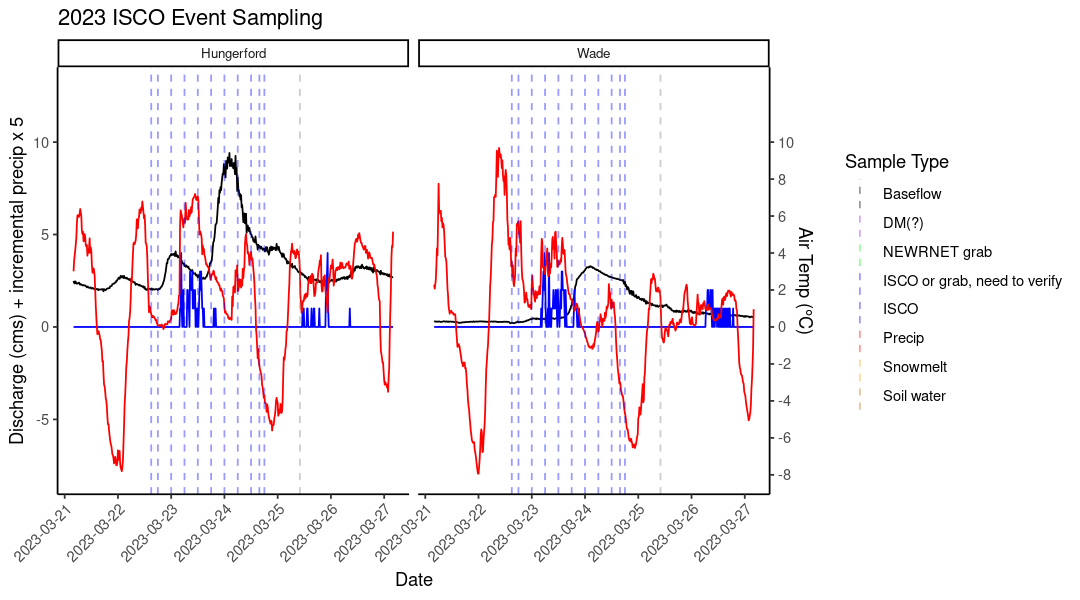

In [63]:
#################
# LOAD PACKAGES #
#################

library(tidyverse)
library(viridis)
library(dplyr)
library(lubridate)
library(caTools)  # for numerical integration
library(data.table) # for nearest join of q and ISCO data

###################
# SET DIRECTORIES #
###################

q_input_dir <- "~//OneDrive/git-repos/cQ_analysis/millar2021_R_separation_hysteresis/sonya-may24/data"
c_input_dir <- "~//OneDrive/git-repos/EMMA/isco_metadata/LCBP_RI_sample_index/"
m_input_dir <- "~//OneDrive/git-repos/cQ_analysis/baseflow-rules-determinaton/data/"
output_dir <- "~//OneDrive/git-repos/EMMA/output/"

##########################
# READ IN AND CLEAN DATA #
##########################

# read in the RI23 data
# see joining here: 
# https://github.com/MeganEDuffy/EMMA/blob/main/isco_metadata/LCBP_RI_sample_index/RI23-sample-ID-join.ipynb
MetadataISCO <- read_csv(file.path(c_input_dir, "RI23-IC-ICP-isotope-joined.csv")) %>%
    filter(Site == 'Hungerford')

# Convert the "Date" column to date format and Time to time format
MetadataISCO$Date <- mdy(MetadataISCO$Date)  # mdy() parses dates in "month/day/year" format 

# Combine Date, Time, and Time zone columns into a single Datetime column
MetadataISCO <- MetadataISCO %>%
  mutate(Datetime = ymd_hms(paste(Date, format(Time, "%H:%M:%S"), "Time Zone")))

# Read in the q data
Hungerford_q <- read_csv(file.path(q_input_dir, "hb_q_chem.csv")) %>%
  mutate(q_cms = q_cms_hb)
Wade_q <- read_csv(file.path(q_input_dir, "wb_q_chem.csv")) %>%
  mutate(q_cms = q_cms_wb)

# Read in the met data for air temp
Hungerford_m <- read_csv(file.path(m_input_dir, "hungerford_2020-2024_met_2024-11-08.csv")) %>%
  filter(Timestamp > as.Date("2023-01-01 00:00:00"), 
        Timestamp < as.Date("2023-04-20 00:00:00")) %>%
  mutate(Stream = "Hungerford")
  
Wade_m <- read_csv(file.path(m_input_dir, "wade_2020-2024_met_2024-11-08.csv")) %>%
  filter(Timestamp > as.Date("2023-01-01 00:00:00"), 
        Timestamp < as.Date("2023-04-20 00:00:00")) %>%
  mutate(Stream = "Wade")

#######################
# PLOT THE HYDROGRAPH #
#######################

# Remove rows with NA for Air_Temp for Wade and Precip
Wade_m_clean <- Wade_m %>% filter(!is.na(Air_Temp))
Wade_m_clean <- Wade_m %>% filter(!is.na(Precip_Increm))

hydrograph_plot_ISCO_with_lines <- ggplot() +
  # Plot stream discharge data for each stream
  geom_line(data = combined_data, aes(x = datetime, y = q_cms), color = "black") +

  # Plot incremental precip for each stream
  geom_line(data = Hungerford_m, aes(x = Timestamp, y = Precip_Increm * 5), color = "blue") +
  geom_line(data = Wade_m_clean, aes(x = Timestamp, y = Precip_Increm * 5), color = "blue") +
  
  # Add air temperature data from Hungerford
  geom_line(data = Hungerford_m, aes(x = Timestamp, y = Air_Temp), color = "red") +
  
  # Add air temperature data from Wade
  geom_line(data = Wade_m_clean, aes(x = Timestamp, y = Air_Temp), color = "red") +
  
  # Add vertical lines for each sample type within the correct stream's facet
  geom_vline(data = MetadataISCO, aes(xintercept = Datetime, color = Type), linetype = "dashed", alpha = 0.4) +
  
  theme_classic() +
  scale_x_datetime(
    limits = c(as.POSIXct('2023-03-21 00:00:00'), as.POSIXct('2023-03-27 00:00:00')),
    date_labels = "%Y-%m-%d",
    date_breaks = "1 day"
  ) +
  # Primary y-axis for discharge
  scale_y_continuous(
    name = "Discharge (cms) + incremental precip x 5",
    limits = c(-8, 13),
    # Secondary y-axis for air temperature
    sec.axis = sec_axis(~ ., name = "Air Temp (°C)", breaks = seq(-10, 10, 2))
  ) +
  labs(title = "2023 ISCO Event Sampling",
       x = "Date",
       color = "Sample Type") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        strip.text = element_text(size = 8)) +
  
  # Use facet_wrap to separate data by Stream
  facet_wrap(~ Stream, ncol = 2) +
  
  # Define colors for each sample type in the legend
  scale_color_manual(
    values = c("Isco" = "blue", "Grab/Isco" = "blue", "Baseflow" = "black", "Snow" = "red", "Precip" = "red",
               "Snowmelt lysimeter" = "orange", "Soil water lysimeter" = "darkorange3", "DM" = "purple", 
               "Grab" = "green"),
    labels = c("Isco" = "ISCO", 
               "Snow" = "Snow", "Precip" = "Precip", "Baseflow" = "Baseflow", "Snowmelt lysimeter" = "Snowmelt", 
               "Soil water lysimeter" = "Soil water", "DM" = "DM(?)", "Grab" = "NEWRNET grab", "Grab/Isco" = "ISCO or grab, need to verify")
  )

# Save the plot with specified dimensions
ggsave(file.path(output_dir, "RI23_hydrograph_plot_ISCO_with_lines.png"), plot = hydrograph_plot_ISCO_with_lines, width = 14, height = 6, dpi = 500)

# Display the plot
print(hydrograph_plot_ISCO_with_lines)